# 16 - Source Wavefield Reconstruction Strategy
<br />

<div style="text-align: justify"> This notebook shows how to reconstruct backward in time the source wavefield when proper initial conditions and boundary values are chosen. This strategy is one among others adopted by the industry, to deal with the need to store the source wavefield over time to later calculate the gradient, which is propagated in the reverse direction in time. Since the acoustic wave equation, in a heterogeneous but without dissipation medium is invariant under a time reverse operation, setting the proper boundary conditions and initial values allow time reversal of the source wavefield. Therefore, the gradient can be calculated with an additional propagation without the need to store the source wavefield snapshots. For this, it would be necessary, first of all, to propagate the source field, storing it at the edges for all time steps. Then, during the reverse propagation, the previously saved wavefield is injected at the same positions as they were saved and reconstructed backwards in time in an additional discretization of the wave equation. This approach can be useful when it is not possible to save the source field in memory, which is the case for most realistic cases, and is also an alternative to using the optimal checkpointing scheme, which requires many intermediate states of wavefield to be stored in memory. To implement this source wavefield reconstruction using Devito, the following requirements are needed  </div>

## Requirements

- Save the source wavefield at the just within the absorbing domain at each time step. 

<div style="text-align: justify">  This wavefield is used later as boundary conditions. At this time, Devito's SparseTimeFunction type is used to to handle the points in which the preassure wavefiled needs to be saved. Using Dussaud et al (2008)'s sugestion, in what follows this tutorial, d/2 layers of data need to be stored at each boundary, where d is the order of spatial finite-difference scheme. As shown in the figure below, the grid points represented by the blue circles are the positions where the pressure field is saved. In this particular case, considering that the discretization was 8th-order in space. Also, the inner rectangle, with black borders, is the simulation domain, and the blue dots are in the absorbing area. </div>

<img src="boundary.png" style="width:300px;"/>

- Inject the wavefield that was saved at the boundaries during backpropagation.

<div style="text-align: justify">  Let's start with the first step of saving the wavefields at the boundaries using the second order acoustic wave equation during forward propagation in a homogeneous model. </div>
    


In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

## Defining the physical model

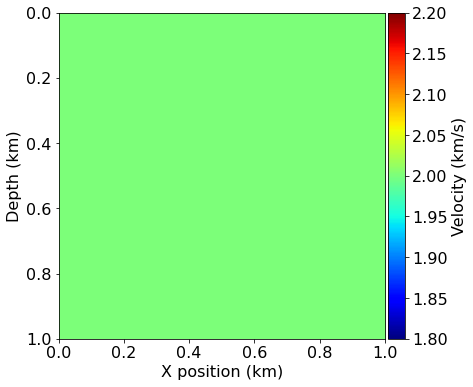

In [2]:
from examples.seismic import Model
from examples.seismic import plot_velocity, plot_image

# Entering model dimensions
shape = (101, 101)  
spacing = (10., 10.) 
origin = (0., 0.)  

# Define a homogeneous velocity model
v = 2 * np.ones(shape, dtype=np.float32)

# Using second-order discretization in space, 
# so the wavefield only needs to be saved in one line 
# around the model.
space_order = 2
nbl = 40
model0 = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbl=nbl, bcs="damp")

plot_velocity(model0)

## Acquisition geometry

As usual, we define the geometry. In this example, choosing a source located right in the middle of the velocity model, the receivers will not be relevant in this check.

In [3]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

nreceivers = shape[0]
t0 = 0
tn = 800.

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model0.domain_size) * .5

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model0.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry
geometry = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker')

## Calculating the grid points in which the wavefield is stored

The function below is to define the type available in Devito today to save the field in the necessary positions described above. According to the spatial discretization order, the function returns the SparseTimeFunction which contains the coordinates in which the fields need to be saved.

In [4]:
from devito.types import SparseTimeFunction

def boundary(model, geom, space_order):
    """
    Calculates grid coordinates that are used to 
    store the field just inside the pml. The number 
    of layers that need to be saved depends on the 
    stencil used. For example, if space order = 2, 
    then 1 layer needs to be stored on each edge. 
    If space_order = 16, 8 layers will be stored for 
    each side of the model.
    ----------
    model : Model
        Object containing the physical parameters.    
    geometry : AcquisitionGeometry
        Geometry object that contains the source (SparseTimeFunction) 
        and receivers (SparseTimeFunction) and their position.        
    space_order : int, optional
        Space discretization order.	
    """
    nx = model.shape[0]
    nz = model.shape[1]
    d  = space_order//2
    npoints = 2*d*nz + 2*d*(nx-2*d)    
        
    bnd = np.empty((npoints, 2))
    
    #left 
    icount = 0
    for i in range(d):
        for iz in range(nz):
            bnd[icount, 0] = i*model.spacing[0] 
            bnd[icount, 1] = (iz)*model.spacing[1] 
            icount = icount + 1
    #rigth              
    for i in range(d):
        for iz in range(nz):            
            bnd[icount, 0] = (nx-i-1)*model.spacing[0] 
            bnd[icount, 1] = (iz)*model.spacing[1] 
            icount = icount + 1            
  
    #top 
    for i in range(d):    
        for ix in range(d,nx-d):
            bnd[icount, 0] = ix*model.spacing[0]  
            bnd[icount, 1] = i*model.spacing[1]  
            icount = icount + 1

    #bottom
    for i in range(d):    
        for ix in range(d,nx-d):
            bnd[icount, 0] = ix*model.spacing[0] 
            bnd[icount, 1] = (nz-i-1)*model.spacing[1]
            icount = icount + 1  
    
    sparse_bnd = SparseTimeFunction(name='sparse_bnd', grid=model.grid, 
                                    nt=geometry.nt, npoint=npoints, 
                                    coordinates=bnd)     
    
    return sparse_bnd

## Forward Propagation (source wavefield)

Once we have the points at which we will need to store the source field, we can perform direct propagation as in the following function

In [5]:
from devito import Eq, Operator, Function, TimeFunction, solve, Inc
from examples.seismic.acoustic import iso_stencil

def forward(model, geom, space_order=2, save=False):
    
    s = model.grid.stepping_dim.spacing
    
    # Boundary info
    bnd = boundary(model, geom, space_order) 

    # Source wavefield
    u = TimeFunction(name="u", grid=model.grid, time_order=2, 
                     save=geom.nt if save else None, space_order=2)
    
    # often used as a preconditioner, let's also save the squared source 
    # wavefield, to compare with the field that will be reconstructed next.
    u2 = Function(name='u2', grid=model.grid)                     
    
    # Derive stencil from symbolic equation
    eqn = model.m * u.dt2 - u.laplace + model.damp * u.dt
    stencil = [Eq(u.forward, solve(eqn, u.forward))]
    
    # inject source into its position
    source = geom.src.inject(field=u.forward, expr=geom.src*s**2 / model.m)
    
    # Get the preassure wavefield at the boudaries using the SparseTimeFunction
    eqb = bnd.interpolate(expr=u)
    
    # Accumulates forward field squared 
    u2_update = Inc(u2, u * u)
    
    # Create and execute operator kernel
    op = Operator([stencil] + source + eqb + [u2_update], subs=model.spacing_map, name='Forward')
                  
    # Apply operator
    op.apply(dt=model.critical_dt)
    
    return bnd, u, u2

Next, we run the forward propagation by setting <em>save=True</em> to compare with later reconstruction.

In [6]:
bnd, u, u2 = forward(model0, geometry, space_order=space_order, save=True)

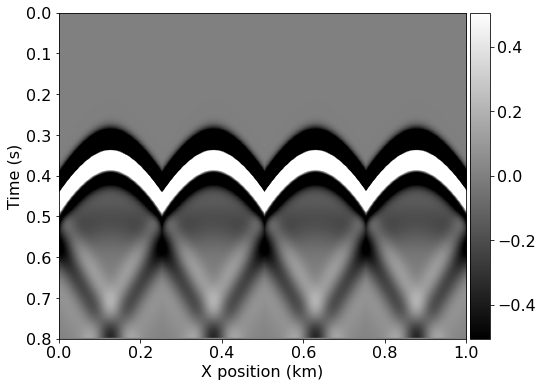

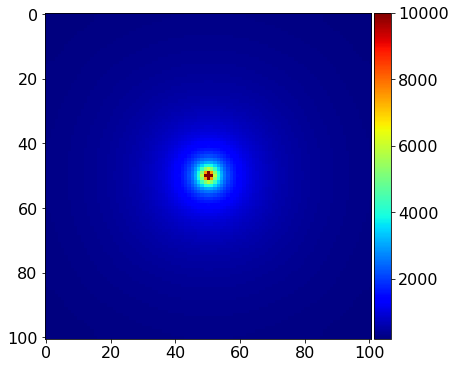

In [7]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_image
from examples.seismic import plot_shotrecord

plot_shotrecord(bnd.data, model0, t0, tn)
plot_image(u2.data[model0.nbl:-model0.nbl,model0.nbl:-model0.nbl],cmap='jet',vmax=1e4)

## Reconstructing source wavefield

In this step, it is necessary to provide the boundary conditions that will be applied at each time step and also the initial conditions. The boundary conditions are stored in the variable <em>bnd</em> above, and the last two snapshots of the forward propagation must be passed to the backpropagation field.

In [8]:
def backward(model, geom, u, boundary, space_order=2, save=False):
    
    m = model.m
    s = model.grid.stepping_dim.spacing

    # Symbol that keeps the reconstructed wavefield squared 
    v2 = Function(name='v2', grid=model.grid)
 
    # Reconstructed wavefield
    v = TimeFunction(name="v", grid=model.grid, time_order=2, 
                     save=geometry.nt if save else None, space_order=2)
    
    # Set initial conditions
    v.data[-1,:,:] = u.data[-1,:,:]
    v.data[-2,:,:] = u.data[-2,:,:]
    
    s = model.grid.stepping_dim.spacing
    
    # Derive stencil from symbolic equation
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(eqn, v.backward))]
    
    # Insert boundary conditions
    eqb = boundary.inject(field=v.backward, expr=boundary, p_t=model.grid.time_dim-1, increment=False)
    
    # remove source
    # An important step in this reconstruction is the removal of the wavelet that was inserted 
    # during the forward propagation. Here we add the source so that it interacts 
    # destructively with the wavelet that is backpropagated.
    src_term = geom.src.inject(field=v.backward, expr=geom.src*s**2 / m, increment=True)
    
    # Accumulates forward field squared (gamma v)
    v2_update = Inc(v2, v * v)

    # Substitute spacing terms to reduce flops
    op = Operator([stencil] + eqb + src_term + [v2_update], subs=model.spacing_map,
                  name='backward')      
                  
    # Apply operator
    op.apply(dt=model.critical_dt)
    
    return v, v2

In [9]:
v, v2 = backward(model0, geometry, u, bnd, space_order=space_order, save=True)

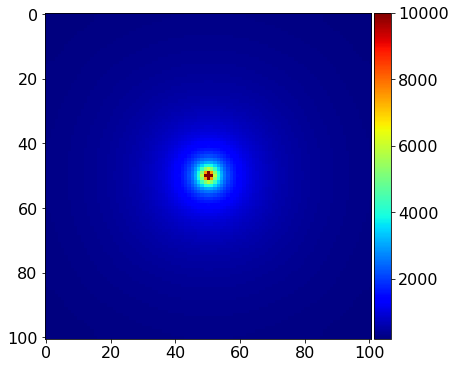

In [10]:
plot_image(v2.data[model0.nbl:-model0.nbl,model0.nbl:-model0.nbl],cmap='jet',vmax=1e4)

On a more visual check, we can see the difference between the accumulated quadratic fields below.

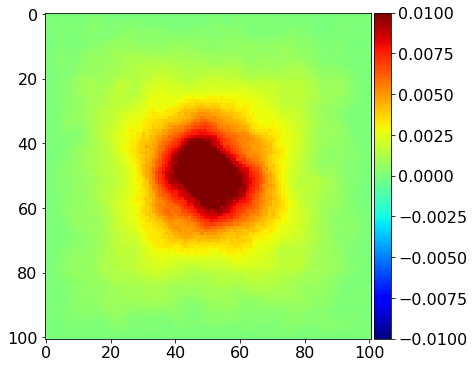

In [11]:
image = -(v2.data[model0.nbl:-model0.nbl,model0.nbl:-model0.nbl]-
          u2.data[model0.nbl:-model0.nbl,model0.nbl:-model0.nbl]) 

plot_image(image,cmap='jet',vmin=-1e-2,vmax=1e-2)

However, to quantitatively analyze the quality of the source field reconstruction, one can use the reconstruction ratio R proposed by <em> Feng, B., and H. Wang, 2012</em>.

$$
R = 1 - \frac{\int \int_{\Omega} | u_f(\mathbf{x},t) - u_b(\mathbf{x},t)|^2 d\mathbf{x}dt}{\int \int_{\Omega} | u_f(\mathbf{x},t)|^2 d\mathbf{x}dt} 
$$

where $u_f$ is the forward propagated wavefield, and $u_b$ is what was reconstructed from the boundary and initial conditions.

In [12]:
from devito import norm

term1 = np.linalg.norm(u.data[:,nbl:-nbl,nbl:-nbl] - 
                       v.data[:,nbl:-nbl,nbl:-nbl])**2
term2 = np.linalg.norm(u.data[:,nbl:-nbl,nbl:-nbl])**2
R = 1 -  term1 / term2
            
R

0.999999999981469

## FWI using the source wavefield reconstruction strategy 

Next, we use the strategy described above to calculate the adjoint operator performing a FWI example using the same parameters as in tutorial 03, for comparison sake.


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

At first, the parameters for the FWI and the true and initial models are created as in tutorial 03.


In [3]:
nshots = 9  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations


## True and smooth velocity models

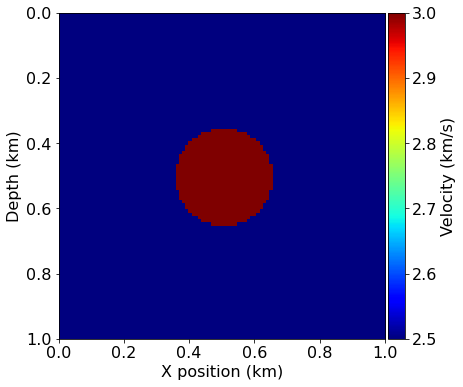

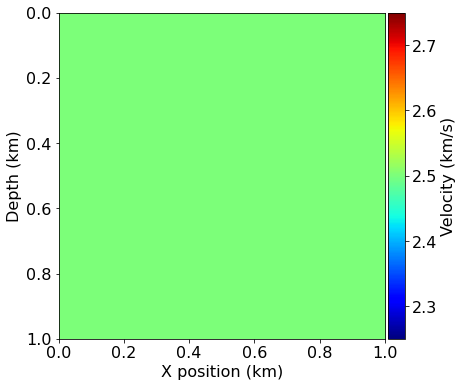

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations
space_order = 4
nbl = 40

true_model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=nbl,
                    space_order=space_order)

smooth_model = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=nbl,
                     space_order=space_order)

plot_velocity(true_model)
plot_velocity(smooth_model)

## Acquisition geometry

In [5]:
from examples.seismic import AcquisitionGeometry

def set_geometry(model, nsrc, nrec, f0, tn, t0=0):  

    src_coordinates = np.empty((nsrc, 2))
    src_coordinates[:, 0] = 30.0
    src_coordinates[:, 1] = np.linspace(0., model.domain_size[1], num=nsrc)

    # Define acquisition geometry: receivers
    # Initialize receivers for synthetic and imaging data
    rec_coordinates = np.empty((nreceivers, 2))
    rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
    rec_coordinates[:, 0] = 980.

    # Geometry
    geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                                   t0, tn, f0=f0, src_type='Ricker')

    return geometry

#set geometry
f0 = 0.010
tn = 1000.
geometry = set_geometry(true_model, nshots, nreceivers, f0, tn)             
geometry0= set_geometry(smooth_model, nshots, nreceivers, f0, tn)  

## Forward propagation

Before performing the forward propagation, it is necessary to define the grid points where the wavefield will be saved, this is done with the function below and depends on the size of the finite difference stencil.

In [6]:
from devito.types import SparseTimeFunction

def boundary(model, geometry, space_order):
    """
    Calculates the grid coordinates that are used to 
    store the field just inside the pml. The number 
    of layers that need to be saved depends on the 
    stencil used. For example, if space order = 2, 
    then 1 layer needs to be stored on each edge. 
    If space_order = 16, 8 layers will be stored for 
    each side of the model.
    ----------
    model : Model
        Object containing the physical parameters.    
    geometry : AcquisitionGeometry
        Geometry object that contains the source (SparseTimeFunction) and
        receivers (SparseTimeFunction) and their position.        
    space_order : int, optional
        Space discretization order.
	
    """
    nx = model.shape[0]
    nz = model.shape[1]
    d  = space_order//2
    npoints = 2*d*nz + 2*d*(nx-2*d)    
        
    bnd = np.empty((npoints, 2))
    
    #left 
    icount = 0
    for i in range(d):
        for iz in range(nz):
            bnd[icount, 0] = i*model.spacing[0] 
            bnd[icount, 1] = (iz)*model.spacing[1] 
            icount = icount + 1
    #rigth              
    for i in range(d):
        for iz in range(nz):            
            bnd[icount, 0] = (nx-i-1)*model.spacing[0] 
            bnd[icount, 1] = (iz)*model.spacing[1] 
            icount = icount + 1            
  
    #top 
    for i in range(d):    
        for ix in range(d,nx-d):
            bnd[icount, 0] = ix*model.spacing[0]  
            bnd[icount, 1] = i*model.spacing[1]  
            icount = icount + 1

    #bottom
    for i in range(d):    
        for ix in range(d,nx-d):
            bnd[icount, 0] = ix*model.spacing[0] 
            bnd[icount, 1] = (nz-i-1)*model.spacing[1]
            icount = icount + 1  
    
    sparse_bnd = SparseTimeFunction(name='sparse_bnd', grid=model.grid, 
                                    nt=geometry.nt, npoint=npoints, 
                                    coordinates=bnd)     
    
    return sparse_bnd

In [7]:
from devito import Eq, Operator, Function, TimeFunction, solve, Inc
from examples.seismic.acoustic import iso_stencil
from examples.seismic import Receiver

def forward(model, geom, space_order):

    s = model.grid.stepping_dim.spacing

    # Boundary info
    bnd = boundary(model, geom, space_order)

    # Source wavefield
    u = TimeFunction(name="u", grid=model.grid, time_order=2,
                     save=None, space_order=space_order)

    # squared source, often used as a preconditioner
    u2 = Function(name='u2', grid=model.grid)

    rec = Receiver(name='rec', grid=geom.grid, coordinates=geom.rec_positions,
                   time_range=geom.time_axis, npoint=geom.nrec)

    # Derive stencil from symbolic equation
    eqn = model.m * u.dt2 - u.laplace + model.damp * u.dt
    stencil = [Eq(u.forward, solve(eqn, u.forward))]

    # inject source into its position
    source = geom.src.inject(field=u.forward, expr=geom.src*s**2 / model.m)

    # Create interpolation expression for receivers
    rec_term = rec.interpolate(expr=u)

    # Get the preassure wavefield at the boudaries using the SparseTimeFunction
    eqb = bnd.interpolate(expr=u)

    # Accumulates forward field squared 
    u2_update = Inc(u2, u * u)

    # Create and execute operator kernel
    op = Operator([stencil] + source + eqb + rec_term + [u2_update], 
                   subs=model.spacing_map, name='Forward')

    # Apply operator
    op.apply(dt=model.critical_dt)

    return rec, bnd, u, u2


## Backward propagation

In the following reverse propagation, the wavefield saved at the boudaries are given as well as the initial conditions, the recontruction is made using a TimeFunction called <em>v</em> in the function below. The residue is injected using a diferent TimeFunction (<em>w</em>).

In [8]:
from examples.seismic.acoustic import iso_stencil

def gradient(data, model, geom, u, bnd, space_order):
    m = model.m

    # Wavefield symbols
    grad = Function(name='grad', grid=model.grid)

    # w is the field in which the residue is injected
    w = TimeFunction(name='w', grid=model.grid,
                     save=None,
                     time_order=2, space_order=space_order)

    # Set initial condition
    v = u

    # Wave equations
    s = model.grid.stepping_dim.spacing
    eqn = iso_stencil(v, model, 'OT2', forward=False)
    eqs = iso_stencil(w, model, 'OT2', forward=False)

    # Add expression for receiver injection
    receivers = data.inject(field=w.backward, expr=data * s**2 / m)

    # Insert u at boundaries
    eqb = bnd.inject(field=v.backward, expr=bnd, p_t=model.grid.time_dim - 1, increment=False)

    # Remove source
    src_term = geom.src.inject(field=v.backward, expr=geom.src * s**2 / m, increment=True)

    # Accumulates backwards field squared (gamma w)    
    grad_update = Inc(grad, - v * w.dt2)

    op = Operator(eqn + eqs + eqb + src_term + receivers + [grad_update], subs=model.spacing_map,
                    name='Gradient')

    op.apply(dt=model.critical_dt)

    return grad                    

## Full-Waveform Inversion

As scipy expects, the following function returns objective function value and gradient

In [9]:
from examples.seismic import Receiver

def fwi_objective_shot(isrc, model, geometry, data, space_order):
    
    # Geometry for current shot
    geometry_i = AcquisitionGeometry(model, geometry.rec_positions, 
                                     geometry.src_positions[isrc,:],
                                     geometry.t0, geometry.tn, f0=geometry.f0, 
                                     src_type=geometry.src_type)    

    # Devito objects for data residual
    residual = Receiver(name='rec', grid=model.grid,
                        time_range=geometry_i.time_axis, 
                        coordinates=geometry_i.rec_positions)
    
    # Forward propagation
    d_pred, bnd, u, _ = forward(model, geometry_i, space_order)        

    residual.data[:] = d_pred.data[:] - data.resample(geometry_i.dt).data[:][0:d_pred.data.shape[0], :]
    
    # Function value and gradient    
    fval = .5*np.linalg.norm(residual.data.flatten())**2
    
    # Backward propagation
    grad_reconst = gradient(residual, model, geometry_i, u, bnd, space_order)
            
    # RWII approximation
    grad_crop = grad_reconst.data[model.nbl:-model.nbl,model.nbl:-model.nbl]   
    
    return fval, grad_crop.flatten().astype(np.float32)


As in tutorial 04, to use the scipy optimizer the following warper needs to be defined


In [10]:
# Wrapper for scipy optimizer: x is current model in squared slowness [s^2/km^2]
def loss(x, model, geometry, data, space_order):

    # Convert x to velocity
    v_curr = 1.0/np.sqrt(x.reshape(model.shape))

    # Overwrite current velocity in geometry (don't update boundary region)
    model.update('vp', v_curr.reshape(model.shape))

    fval = 0
    grad = np.zeros(model.shape[0]*model.shape[1],dtype=np.float32)
    for i in range(geometry.nsrc):        
        args = [i, model, geometry, data[i], space_order]
        fval += fwi_objective_shot(*args)[0]
        grad += fwi_objective_shot(*args)[1]
                        
    return fval, grad

Calculating the generated data with the true model


In [11]:
from examples.seismic.acoustic import AcousticWaveSolver

def forward_modeling_shot(isrc, model, geom, space_order):
    
    # Geometry for current shot
    geometry_i = AcquisitionGeometry(model, geom.rec_positions, geom.src_positions[isrc,:],
                                     geom.t0, geom.tn, f0=geom.f0, src_type=geom.src_type)                                   

    solver = AcousticWaveSolver(model, geometry_i, space_order=space_order)
    d_obs, _, _ = solver.forward(vp=model.vp)

    return d_obs

dobs = []
for i in range(geometry.nsrc):
    args = [i, true_model, geometry, space_order]
    dobs.append(forward_modeling_shot(*args))

Running the 2D FWI example by calling the ```optimize.minimize``` function:

In [12]:
from scipy import optimize
from examples.seismic import plot_image

# Initial guess
v0 = smooth_model.vp.data[nbl:-nbl, nbl:-nbl]
m0 = 1.0 / (v0.reshape(-1).astype(np.float32))**2

# FWI with the conjugate gradient method
result = optimize.minimize(loss, m0, args=(smooth_model, geometry0, dobs, space_order), method='CG', jac=True,
                           options={'maxiter':fwi_iterations, 'disp':True})
print(result)

         Current function value: 240.545472
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
     fun: 240.54547232020673
     jac: array([-32.624546, -33.016766, -31.025126, ...,  47.275032,  40.43739 ,
        29.714577], dtype=float32)
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 11
     nit: 5
    njev: 11
  status: 1
 success: False
       x: array([0.16538788, 0.16400471, 0.16280915, ..., 0.15776934, 0.15828195,
       0.15899657], dtype=float32)


Plotting inverted velocity

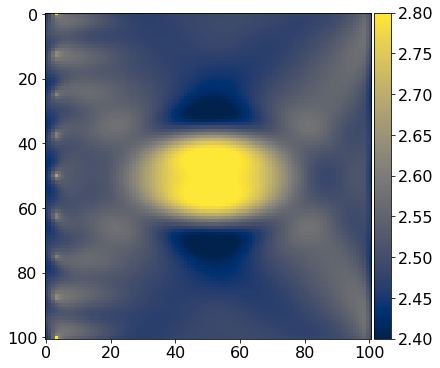

In [13]:
vp = 1.0/np.sqrt(result['x'].reshape(true_model.shape))
plot_image(vp,vmin=2.4, vmax=2.8, cmap="cividis")

## References

[1] _Feng, B., and H. Wang, 2012, Reverse time migration with source wavefield reconstruction strategy: Journal of Geophysics and Engineering, 9, 69–74_

[2] _Dussaud E, Symes W W, Williamson P, Lemaistre L, Singer P, Denel B and Cherrett A 2008. Computational strategies for reverse-time migration 78th Ann. Int. Mtg. Soc. Expl. Geophys. pp 2267–71 (expanded abstract)_